# **Imports**

In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from netCDF4 import Dataset
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Suppressing warnings
warnings.filterwarnings("ignore")

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# **Architectures**

## **Standard VAE model**

In [59]:
class Std_Encoder(tfk.Model):

    def __init__(self):
        super(Std_Encoder,self).__init__()
        self.encoded_size =4
        self.prior        = tfd.MultivariateNormalDiag(loc=tf.zeros(self.encoded_size))
        self.dense1       = tfkl.Dense(5,activation='relu')
        self.dense2       = tfkl.Dense(5,activation='relu')
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.dense3       = tfkl.Dense(tfpl.IndependentNormal.params_size(self.encoded_size))
        self.ind_norm1    = tfpl.IndependentNormal(self.encoded_size,
                                                   activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,
                                                                                                     weight=1.0))

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.lambda1(x)
        x = self.dense3(x)
        x = self.ind_norm1(x)
        return x

class Std_Decoder(tfk.Model):
    def __init__(self):
        super(Std_Decoder,self).__init__()
        self.K         = 4
        self.dense1    = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense2    = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense3    = tfkl.Dense(tfpl.IndependentNormal(self.K).params_size(self.K))
        self.lambda1   = tfkl.Lambda(lambda x: tf.abs(x)+0.001)
        self.ind_norm1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda v: tfd.TruncatedNormal(
                                loc=v[...,0], scale=v[...,1],low = 0,high = 1000))


    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.lambda1(x)
        x = self.ind_norm1(x)
        return x

class Std_VAE(tfk.Model):
    def __init__(self):
        super(Std_VAE,self).__init__()
        self.encoder = Std_Encoder()
        self.decoder = Std_Decoder()

    def call(self,inputs):
        return self.decoder(self.encoder(inputs))

In [60]:
#Model for radius generation with known prior
class Encoder(tfk.Model):

    def __init__(self):
        super(Encoder,self).__init__()
        #self.prior        = tfd.Gamma(concentration=1.5,rate = 1)
        self.prior        = tfd.Gamma(concentration=4.5,rate = 1)
        self.dense1       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense2       = tfkl.Dense(5, activation ='relu',kernel_initializer =tfk.initializers.Zeros())
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda1      = tfkl.Lambda(lambda x: tf.abs(x)+0.001, name='posterior_params')
        self.dist_lambda1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: tfd.Gamma(
                                concentration=t[...,0], rate = t[...,1]),
                                    activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,use_exact_kl =True))


    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.lambda1(x)
        x = self.dist_lambda1(x)
        return x

class Decoder(tfk.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.dense1       = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1      = tfkl.Lambda(lambda x: 1/x)
        self.dense2       = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31      = tfkl.Dense(1, use_bias=True,bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.dense32      = tfkl.Dense(1, use_bias=True,bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2), kernel_initializer = tfk.initializers.RandomUniform(minval=0.1, maxval=2))
        self.dense3       = tfkl.Dense(2, activation='relu',bias_initializer = tfk.initializers.RandomUniform(minval=1, maxval=2))
        self.lambda2      = tfkl.Lambda(lambda x: tf.abs(x)+0.00001)
        self.concat1      = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))
        self.dist_n       = tfpl.IndependentNormal(1)
        self.ind_norm1 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda v: tfd.TruncatedNormal(
                                loc=v[...,0], scale=v[...,1],low = 0,high = 1000))


    def call(self, inputs):
        y     = tfkl.Reshape(target_shape=[1])(inputs)
        y1    = self.lambda1(y)
        x     = self.dense1(y1)
        x     = self.dense2(x)

        #for gamma output :
        alpha = self.dense31(x*y)
        alpha = self.lambda1(alpha)
        beta  = self.dense32(x)
        beta  = self.lambda2(beta*y**2)
        x     = self.concat1([alpha,beta])
        x     = self.dist_lambda1(x)

        #normal output or truncated normal:
        #mu    = self.dense31(x)
        #sig   = self.dense32(x)
        #sig   = self.lambda1(sig/(1+y1))
        #x     = self.concat1([mu,sig])
        #x     = self.dist_n(x)
        #x     = self.ind_norm1(x)

        return x

class Ext_VAE(tfk.Model):
    def __init__(self):
        super(Ext_VAE,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self,inputs):
        return self.decoder(self.encoder(inputs))

## **VAE for radius generation with learned tail index of the prior**

In [ ]:
class U_Encoder(tfk.Model):
    """
    An encoder model for the U-Ext-VAE model.
    """
    def __init__(self):
        super(U_Encoder, self).__init__()

        # Define the prior distribution for the latent variables
        self.alpha = 1.5  # Prior on the concentration parameter of the Gamma distribution
        self.prior = self.make_mvn_prior(1, False)  # Make the prior a trainable Gamma distribution

        # Define the dense layers of the encoder network
        self.dense1 = tfkl.Dense(5, activation='relu', kernel_initializer=tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense2 = tfkl.Dense(5, activation='relu', kernel_initializer=tfk.initializers.RandomUniform(minval=0.01, maxval=0.02))
        self.dense3 = tfkl.Dense(2, activation='relu', bias_initializer=tfk.initializers.RandomUniform(minval=3.0, maxval=5.5))

        # Define the transformation layer for the latent variables
        self.lambda1 = tfkl.Lambda(lambda x: tf.abs(x) + 0.001)

        # Define the distribution over the latent variables
        self.dist_lambda3 = tfpl.DistributionLambda(
                            make_distribution_fn=lambda t: (tfd.Gamma(
                                concentration=t[...,0], rate=t[...,1])),
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, use_exact_kl=True))

    def make_mvn_prior(self, ndim, Trainable=True):
        """
        Creates a trainable or non-trainable Gamma prior distribution.

        Args:
            ndim (int): The dimensionality of the prior distribution.
            Trainable (bool): Whether the prior distribution is trainable.

        Returns:
            tfd.Gamma: The Gamma prior distribution.
        """
        if Trainable:
            # Define the concentration and rate parameters of the Gamma distribution as trainable variables
            c = tf.Variable(tf.random.uniform([ndim], minval=3.5, maxval=5.5, dtype=tf.float32), name='prior_c')
            rate = 1
        else:
            # Use fixed values for the concentration and rate parameters of the Gamma distribution
            c = self.alpha
            rate = 1

        # Create and return the Gamma prior distribution
        prior = tfd.Gamma(concentration=c, rate=rate)
        return prior

    def call(self, inputs):
        """
        Encodes the input data into a latent variable representation.

        Args:
            inputs (tf.Tensor): The input data.

        Returns:
            tfp.Distribution: The distribution over the latent variables.
        """
        # Pass the input data through the dense layers of the encoder
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)

        latent_variables = self.dist_lambda3(x)

        return latent_variables

class U_Decoder(tfk.Model):
    """
    A decoder model for the U-Ext-VAE model.
    """
    def __init__(self):
        super(U_Decoder, self).__init__()

        # Define the dense layers of the decoder network
        self.dense1 = tfkl.Dense(5, use_bias=True, activation='relu')
        self.lambda1 = tfkl.Lambda(lambda x: 1 / x)
        self.dense2 = tfkl.Dense(5, use_bias=True, activation='relu')
        self.dense31 = tfkl.Dense(1, use_bias=True)
        self.dense32 = tfkl.Dense(1, use_bias=True)
        self.lambda2 = tfkl.Lambda(lambda x: tf.abs(x) + 0.001)
        self.concat1 = tfkl.Concatenate()
        self.dist_lambda1 = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Gamma(
                concentration=t[...,0], rate=t[...,1]))

    def call(self, inputs):
        """
        Decodes the latent variable representation into the reconstructed data.

        Args:
            inputs (tfp.Distribution): The distribution over the latent variables.

        Returns:
            tfp.Distribution: The distribution over the reconstructed data.
        """

        # Pass the latent variables through the dense layers of the decoder
        y1 = tfkl.Reshape(target_shape=[1])(inputs)
        y = self.lambda1(y1)
        x = self.dense1(y)
        x = self.dense2(x)

        # Obtain the parameters of the Gamma distribution over the reconstructed data
        alpha = self.dense31(x)
        alpha = self.lambda2(alpha * y1)
        beta = self.dense32(x)
        beta = self.lambda2(beta / y**2)

        # Concatenate the parameters of the Gamma distribution
        x = self.concat1([alpha, beta])

        # Define and return the distribution over the reconstructed data
        reconstructed_data = self.dist_lambda1(x)
        return reconstructed_data

class U_Ext_VAE(tfk.Model):
    """
    The U-Ext-VAE model.
    """
    def __init__(self):
        super(U_Ext_VAE, self).__init__()
        self.encoder = U_Encoder()
        self.decoder = U_Decoder()

    def call(self, inputs):
        """
        Encodes the input data, generates the reconstructed data, and computes the loss.

        Args:
            inputs (tf.Tensor): The input data.

        Returns:
            tf.Tensor: The loss.
        """
        # Encode the input data into the latent variable representation
        latent_variables = self.encoder(inputs)

        # Decode the latent variable representation into the reconstructed data
        reconstructed_data = self.decoder(latent_variables)

        return reconstructed_data

## **VAE for radius-conditioned angular distribution**

In [47]:
class Sphere_Encoder(tfk.Model):
    """
    Encoder model for the Sphere VAE.
    """
    def __init__(self):
        super(Sphere_Encoder, self).__init__()

        self.encoded_size = 4  # Dimensionality of the latent space
        self.prior = tfd.Independent(  # Prior distribution for the latent variables
            tfd.Normal(loc=tf.zeros(self.encoded_size), scale=1),
            reinterpreted_batch_ndims=1)
        self.concat = tfkl.Concatenate()  # Layer for concatenating input vectors
        self.dense1 = tfkl.Dense(8, activation='relu')  # Dense layer with ReLU activation
        self.dense2 = tfkl.Dense(8, activation='relu')  # Dense layer with ReLU activation
        self.lambda1 = tfkl.Lambda(lambda x: tf.abs(x) + 0.001)  # Absolute value transformation
        self.dense3 = tfkl.Dense(tfpl.IndependentNormal.params_size(self.encoded_size))  # Dense layer for producing mean and log variance of the latent distribution
        self.ind_norm1 = tfpl.IndependentNormal(  # Independent Normal distribution for the latent variables
            self.encoded_size,
            activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior, weight=1.0))  # KL divergence regularization to enforce prior

    def call(self, inputs):
        """
        Encodes the input data into a latent variable representation.
        """
        inputs1, inputs2 = inputs  # Split the input data into two parts

        x = self.concat([inputs1, inputs2 / 10])  # Concatenate the input parts with a scaling factor for the second part

        x = self.dense1(x)  # Pass the concatenated input through the first dense layer
        x = self.dense2(x)  # Pass the output of the first dense layer through the second dense layer
        x = self.lambda1(x)  # Apply the absolute value transformation
        x = self.dense3(x)  # Pass the transformed input through the third dense layer

        latent_variables = self.ind_norm1(x)  # Generate the latent variable representation using the Independent Normal distribution

        return latent_variables


class Sphere_Decoder(tfk.Model):
    """
    Decoder model for the Sphere VAE.
    """
    def __init__(self):
        super(Sphere_Decoder, self).__init__()

        self.K = 5  # Number of output dimensions
        self.dense1 = tfkl.Dense(5, use_bias=True, activation='relu')  # Dense layer with ReLU activation
        self.dense2 = tfkl.Dense(10, use_bias=True, activation='relu')  # Dense layer with ReLU activation
        self.dense31 = tfkl.Dense(tfpl.IndependentNormal(self.K).params_size(self.K))  # Dense layer for producing mean and log variance of the output distribution
        self.ind_norm11 = tfpl.IndependentNormal(self.K)  # Independent Normal distribution for the output variables
        self.dense32 = tfkl.Dense(5, activation='relu', bias_initializer=tfk.initializers.RandomUniform(minval=2, maxval=3))  # Dense layer with ReLU activation
        self.lambda1 = tfkl.Lambda(lambda x: 1 / (1 + x))  # Transformation to ensure positive values
        self.concat = tfkl.Concatenate()  # Layer for concatenating input vectors

        self.diri12 = tfpl.DistributionLambda(  # Distribution transformer for generating Dirichlet distribution parameters
            make_distribution_fn=lambda c: tfd.Dirichlet(c))

    def call(self, inputs):
        """
        Decodes the latent variable representation into the reconstructed data.
        """
        latent_variables, inputs2 = inputs  # Split the input into latent variables and additional input

        inputs2 = self.lambda1(inputs2)  # Apply the transformation to ensure positive values

        x = self.dense1(latent_variables)  # Pass the latent variables through the first dense layer
        x = self.concat([x, inputs2])
        x = self.dense2(x)  # Pass the concatenated input through the second dense layer

        # Normal output without forcing mu to be on the sphere
        #x = self.dense31(x)
        #reconstructed_data = self.ind_norm11(x)

        # Dirichlet output
        x = self.dense32(x)
        #x = self.lambda12(x)
        reconstructed_data = self.diri12(x)

        return reconstructed_data


class Sphere_VAE(tfk.Model):
    """
    The Sphere VAE model.
    """
    def __init__(self):
        super(Sphere_VAE, self).__init__()
        self.encoder = Sphere_Encoder()
        self.decoder = Sphere_Decoder()

    def call(self, inputs):
        """
        Encodes the input data, generates the reconstructed data, and computes the loss.
        """
        inputs1, inputs2 = inputs  # Split the input data into two parts

        latent_variables = self.encoder([inputs1, inputs2])  # Encode the input data into latent variables
        reconstructed_data = self.decoder([latent_variables, inputs2])  # Decode the latent variables into reconstructed data
        return reconstructed_data

# **Data Loading**

## **Danube Dataset**

In [8]:
ncfile = Dataset('/content/Dataset_danube.nc',"r")
L=[]
for i in range(31):
    L.append(ncfile['S'+str(i+1)][:].reshape(18244,1))

dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)
print(dataset.shape)

(18244, 31)


In [9]:
R4 = dataset[:,22:27]
axis = 1
R4_rad = np.sum(R4,axis)
R4_rad = R4_rad.reshape((18244,1))
R4_S = np.divide(R4,R4_rad)
train_dataset = R4_rad[::25,:]
eval_dataset  = R4_rad
print(train_dataset.shape)
print(np.max(train_dataset))
print(np.max(R4_rad))

(730, 1)
856.9
1899.0


## **Syntetic Dataset**

In [10]:
seed = 10
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [11]:
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X


random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(np.max(R1))
print(np.max(R1[:250]))

223.77151
24.60199


# **Training**

In [ ]:
vae  = U_Ext_VAE()

In [ ]:
checkpoint_filepath = '/content/checkpoint'
metric ='val_loss'
model_checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=metric,
    mode='min',
    save_best_only=True)

In [ ]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [ ]:
enc = vae.encoder
enc.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
            loss=negative_log_likelihood)

enc.fit(x=train_dataset,
	y=train_dataset,
        #validation_data=(eval_dataset,eval_dataset),
        batch_size=32,
        epochs=10)
print(enc.prior.concentration)

Epoch 1/10
23/23 [==============================] - 2s 6ms/step - loss: 531.0094
Epoch 2/10
23/23 [==============================] - 0s 6ms/step - loss: 528.8304
Epoch 3/10
23/23 [==============================] - 0s 6ms/step - loss: 526.8403
Epoch 4/10
23/23 [==============================] - 0s 6ms/step - loss: 524.6515
Epoch 5/10
23/23 [==============================] - 0s 6ms/step - loss: 522.2778
Epoch 6/10
23/23 [==============================] - 0s 6ms/step - loss: 519.8381
Epoch 7/10
23/23 [==============================] - 0s 5ms/step - loss: 517.6841
Epoch 8/10
23/23 [==============================] - 0s 6ms/step - loss: 515.0980
Epoch 9/10
23/23 [==============================] - 0s 6ms/step - loss: 512.2938
Epoch 10/10
23/23 [==============================] - 0s 6ms/step - loss: 509.5571
<tf.Variable 'prior_c:0' shape=(1,) dtype=float32, numpy=array([3.7044716], dtype=float32)>


In [ ]:
vae.fit(train_dataset,train_dataset,
        validation_data=(eval_dataset,eval_dataset),
        batch_size=32,
        epochs=5000,
        callbacks = [model_checkpoint_callback])

Epoch 1/5000
23/23 [==============================] - 6s 135ms/step - loss: 119.6270 - val_loss: 76.3262
Epoch 2/5000
23/23 [==============================] - 3s 118ms/step - loss: 55.1744 - val_loss: 41.3804
Epoch 3/5000
23/23 [==============================] - 3s 124ms/step - loss: 34.0135 - val_loss: nan
Epoch 4/5000
23/23 [==============================] - 4s 173ms/step - loss: 26.6383 - val_loss: nan
Epoch 5/5000
23/23 [==============================] - 3s 118ms/step - loss: 24.1993 - val_loss: nan
Epoch 6/5000
23/23 [==============================] - 3s 118ms/step - loss: 23.1389 - val_loss: 22.2002
Epoch 7/5000
23/23 [==============================] - 3s 116ms/step - loss: 21.2700 - val_loss: 20.9296
Epoch 8/5000
23/23 [==============================] - 3s 121ms/step - loss: 20.2641 - val_loss: 19.7300
Epoch 9/5000
23/23 [==============================] - 4s 177ms/step - loss: 19.8330 - val_loss: 18.8376
Epoch 10/5000
23/23 [==============================] - 3s 117ms/step - loss

KeyboardInterrupt: ignored

In [ ]:
angle_train_dep = R4_S[::25,:]
print(angle_train_dep.shape)
print(train_dataset.shape)
angle_eval_dep  = R4_S
print(angle_eval_dep.shape)

(730, 5)
(730, 1)
(18244, 5)


In [ ]:
metric ='val_loss'
model_checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=metric,
    mode='min',
    save_best_only=True)

In [ ]:
vae = Sphere_VAE()

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
            loss=negative_log_likelihood)

vae.fit([angle_train_dep,train_dataset],angle_train_dep,
        validation_data=([angle_eval_dep,eval_dataset],angle_eval_dep),
        batch_size=32,epochs=5000,
       callbacks = [model_checkpoint_callback])

Epoch 1/5000
23/23 [==============================] - 7s 109ms/step - loss: 93.3745 - val_loss: 3207175680.0000
Epoch 2/5000
23/23 [==============================] - 1s 67ms/step - loss: 94.7563 - val_loss: 27477.0996
Epoch 3/5000
23/23 [==============================] - 1s 67ms/step - loss: 99.3959 - val_loss: 486605.0312
Epoch 4/5000
23/23 [==============================] - 3s 124ms/step - loss: 83.6371 - val_loss: 12346.1514
Epoch 5/5000
23/23 [==============================] - 3s 122ms/step - loss: 92.0202 - val_loss: 7527890.5000
Epoch 6/5000
23/23 [==============================] - 3s 122ms/step - loss: 633.6198 - val_loss: 17022.3223
Epoch 7/5000
23/23 [==============================] - 3s 125ms/step - loss: 1239.9727 - val_loss: 64830.9844
Epoch 8/5000
23/23 [==============================] - 1s 66ms/step - loss: 95.4485 - val_loss: 2586.4731
Epoch 9/5000
23/23 [==============================] - 1s 66ms/step - loss: 427.3176 - val_loss: 1312.8755
Epoch 10/5000
23/23 [==========

# **Testing**

## **Synthetic dataset sampling**

In [61]:
#Checkpoint
checkpoint_path_U = '/content/U_Ext_VAE_checkpoint.index'
checkpoint_path_Std = '/content/Std_VAE_checkpoint.index'
checkpoint_path_Ext = '/content/Ext_VAE_checkpoint.index'


#VAE model selection
vae_test_Std = Std_VAE()
vae_test_Ext = Ext_VAE()
vae_test_U = U_Ext_VAE()

#Load model
vae_test_U.load_weights(checkpoint_path_U)
vae_test_Std.load_weights(checkpoint_path_Std)
vae_test_Ext.load_weights(checkpoint_path_Ext)


In [24]:
# True samples from R1
N_samples = 10000
A = 2*tfd.Uniform().sample(N_samples)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(N_samples)
test_set_Synth = A*X
test_set_Synth = test_set_Synth.numpy()

In [62]:
# Generated radii samples for synthethic dataset

prior_samples_U = vae_test_U.encoder.prior.sample(N_samples)
samples_vae_U = vae_test_U.decoder(prior_samples_U).sample()

prior_samples_Ext = vae_test_Ext.encoder.prior.sample(N_samples)
samples_vae_Ext = vae_test_Ext.decoder(prior_samples_Ext).sample()

prior_samples_Std = vae_test_Std.encoder.prior.sample(N_samples)
samples_vae_Std = vae_test_Std.decoder(prior_samples_Std).sample()

## **Danube dataset sampling**

In [15]:
# Danube dataset
checkpoint_path_Danube = '/content/Danube_checkpoint.index'

vae_test_D = Ext_VAE()
vae_test_D.load_weights(checkpoint_path_Danube)

In [25]:
R4 = dataset[:,22:27]
axis = 1
test_set_Dan = np.sum(R4,axis)
test_set_Dan = test_set_Dan.reshape((18244,1))

prior_samples = vae_test_D.encoder.prior.sample(test_set_Dan.shape)
samples_vae   = vae_test_D.decoder(prior_samples).sample()

## **Comparing estimated and emperical densities**

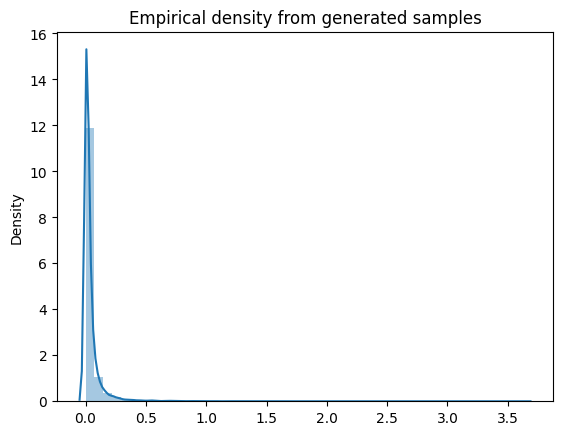

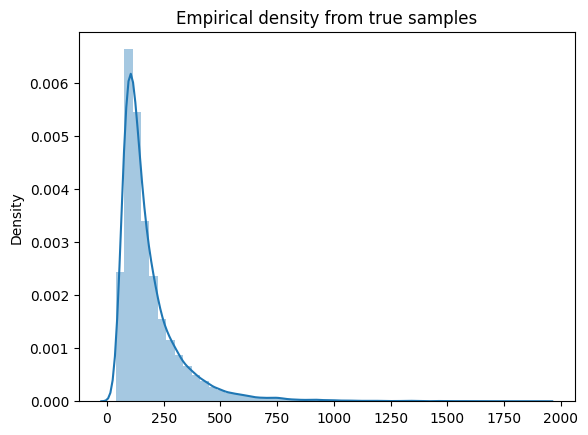

In [17]:
sns.distplot(samples_vae)
plt.title("Empirical density from generated samples")
plt.show()

sns.distplot(test_set)
plt.title("Empirical density from true samples")
plt.show()

In [18]:
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

# Function to modify the tail
def tail_mod(f, n, x):
    return (n / (n + 1)) * (1 - f(x)) + 1 / (n + 1)

def L(X, Y, u):
    Nn = np.sum(X > u)
    m = Y.shape[0]  # Number of elements in Y
    fY = ECDF(Y)    # Empirical cumulative distribution function of Y

    # Compute maximum and minimum values between X and u
    Xmax = np.maximum(X, u)
    Xu = np.minimum(Xmax, u)

    res = 1 + 1 / Nn * np.sum(np.log(tail_mod(fY, m, Xmax) / tail_mod(fY, m, Xu)))
    return res

def K(X, Y, u):
    res = -L(X, Y, u) - L(Y, X, u)
    return res

## **KL divergence test**

2.1816862
KL divergence upon threshold 0.9: -0.17063904297531907


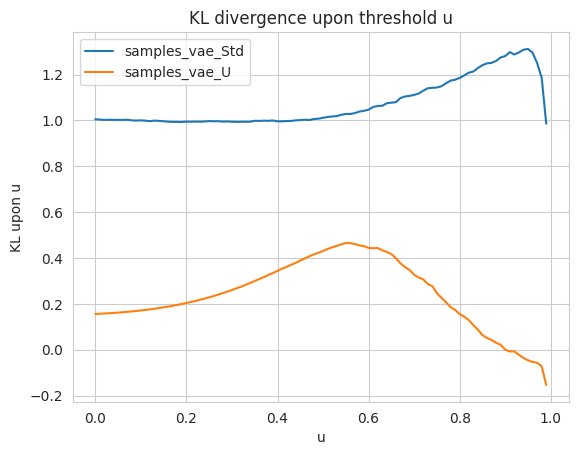

In [65]:
# Calculate the threshold corresponding to quantile q
q = 0.9
u = np.sort(test_set_Synth)[int(q * N_samples)]

# Print the threshold and KL divergence at the threshold
print(u)
print(f"KL divergence upon threshold {q}: {K(test_set_Synth, samples_vae_Std, u)}")

# Create arrays for plotting
X = np.arange(0, 1, 0.01)
Ind = X * 10000
Ind = Ind.astype('int64')

# Get quantiles for different sample sets
Q = np.sort(samples_vae_Std)[Ind]
Q2 = np.sort(samples_vae_Ext)[Ind]
Q3 = np.sort(samples_vae_U)[Ind]

# Calculate KL divergences for different thresholds
Y = [K(test_set_Synth, samples_vae_Std, qi) for qi in Q]
Y2 = [K(test_set_Synth, samples_vae_Ext, qi) for qi in Q2]
Y3 = [K(test_set_Synth, samples_vae_U, qi) for qi in Q3]

# Set Seaborn style and plot
sns.set_style("whitegrid")
plt.figure()
plt.title("KL divergence upon threshold u")
plt.xlabel("u")
plt.ylabel("KL upon u")
plt.plot(X, Y, label='samples_vae_Std')
#plt.plot(X, Y2, label='samples_vae_Ext')
plt.plot(X, Y3, label='samples_vae_U')
plt.legend()
plt.show()

## **Hill Estimator**

In [35]:
def hill_estimator(data):
    """
    Returns the Hill Estimators for a 1D data set.
    """
    # Sort the data in ascending order
    sorted_data = np.sort(data)
    n = len(sorted_data)

    hill_est = np.zeros(n - 1)

    for k in range(n - 1):  # k = 0, ..., n-2
        summ = 0

        for i in range(k + 1):  # i = 0, ..., k
            summ += np.log(sorted_data[n - 1 - i]) - np.log(sorted_data[n - 2 - k])

        hill_est[k] = (1 / (k + 1)) * summ

    hill = 1. / hill_est
    return hill

In [36]:
seed = 100
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
A = 2*tfd.Uniform().sample(1000)
X = tfd.InverseGamma(concentration =1.5, scale = 0.6 ).sample(1000)
R1 = A*X

train_dataset = R1[:250]
train_dataset = tf.reshape(train_dataset,[250,1])
eval_dataset = R1[250:]
eval_dataset=tf.reshape(eval_dataset,[750,1])
print(np.max(R1))
print(np.max(R1[:250]))

100.4905
13.270861


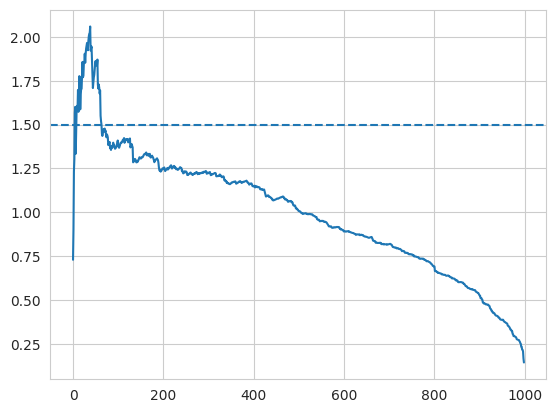

In [37]:
H = hill_estimator(R1)
plt.plot(H)
plt.axhline(1.5, linestyle='--')

## **Angular Measures**

In [38]:
def alphas_function(x):
    res = tf.convert_to_tensor([6. -3.*tf.minimum(1.,0.5/x), 6. -3.*tf.minimum(1.,0.5/x) , 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x), 3.+ 3.*tf.minimum(1.,0.5/x)])
    return(tf.transpose(res))

In [39]:
ax0      = 3
ax1      = 4

rad      = 3 # value of the considered radius
Diri_rad = tfd.Dirichlet(alphas_function(rad))

(1000,)
(1000,)


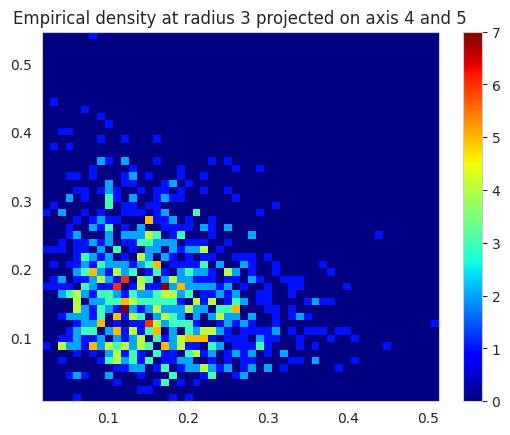

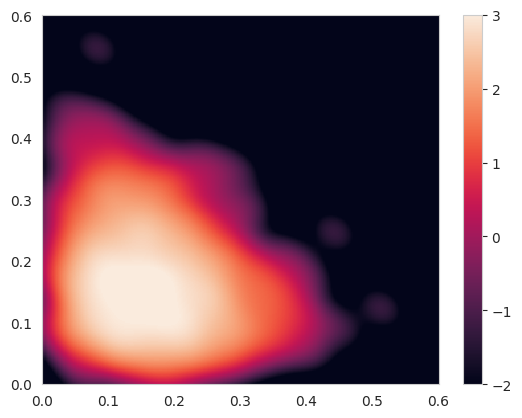

In [40]:
#plot density at given radius r
angles    = Diri_rad.sample(1000).numpy()
angles_x1 = angles[:,ax0]
print(angles_x1.shape)
angles_x2 = angles[:,ax1]
print(angles_x2.shape)
plt.figure()
plt.title(f'Empirical density at radius {rad} projected on axis {ax0 + 1} and {ax1 + 1}')
h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
plt.figure()

from scipy.stats import kde
nbins=300
k = kde.gaussian_kde([angles_x1,angles_x2])
xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))

from matplotlib.colors import Normalize
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', norm=Normalize(vmin=-2,vmax=3))
plt.colorbar()
plt.show()

In [48]:
checkpoint_path = '/content/checkpoint_sphere.index'

vae_sphere = Sphere_VAE()
vae_sphere.load_weights(checkpoint_path)

In [49]:
# Generate samples
prior_samples = vae_sphere.encoder.prior.sample(1000)
angles_dist   = vae_sphere.decoder([prior_samples,rad*tf.ones((1000,1))])
angles_gen    = angles_dist.sample()
angle_gen     = angles_gen/tf.reshape(tf.reduce_sum(angles_gen,axis=1),(1000,1))

(1000,)
(1000,)


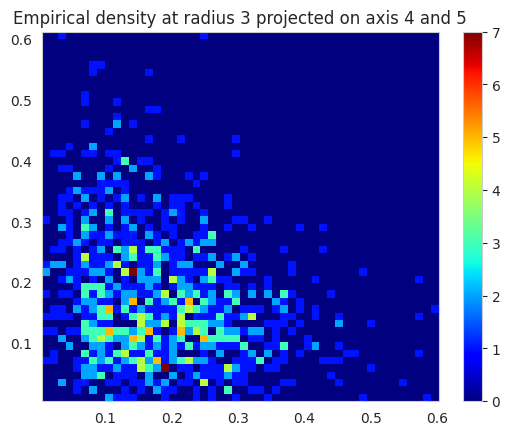

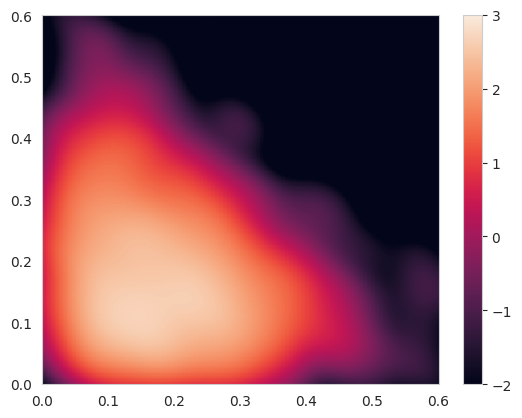

In [50]:
# Plot the density map
angles_x1 = angles_gen.numpy()[:,ax0]
print(angles_x1.shape)
angles_x2 = angles_gen.numpy()[:,ax1]
print(angles_x2.shape)
plt.figure()
plt.title(f'Empirical density at radius {rad} projected on axis {ax0 + 1} and {ax1 + 1}')
h =plt.hist2d(angles_x1, angles_x2,bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
plt.figure()

from scipy.stats import kde
nbins=300
k = kde.gaussian_kde([angles_x1,angles_x2])
xi, yi = np.mgrid[0:0.6:nbins*1j, 0:0.6:nbins*1j]
zi = np.log(k(np.vstack([xi.flatten(), yi.flatten()])))

# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto',norm=Normalize(vmin=-2,vmax=3))
plt.colorbar()
plt.show()